In [3]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.signal import welch

Crgamos los datos

In [4]:
eeg1 = pd.read_csv("participantes/eeg_pp_21.csv")

features1 = pd.read_csv("participantes/eeg_features_21.csv")

In [3]:
eeg1.head()

,latency,fp1,fp2,f7,f3,fz,f4,f8,t7,c3,cz,c4,t8,p7,p3,pz,p4,p8,o1,o2
0,0.00248,-20.778600,-10.637670,240.6483,-13.951820,-19.630210,-6.806858,-68.50114,-55.41396,-23.079560,-17.03370,-25.01113,-34.732330,-35.709910,-26.655010,-18.146500,-19.142000,0.672547,5.358263,-8.396982
1,0.00639,-24.207800,-13.085340,229.4315,-21.688600,-25.350490,-10.343600,-69.61867,-81.91827,-25.270890,-32.83147,-44.24131,-64.938320,-3.873377,11.111620,7.715622,-25.653910,156.189200,149.770500,81.712060
2,0.01029,-10.157220,-1.032855,234.6953,-13.731250,-14.767500,0.058555,-63.80717,-95.59223,-10.271700,-37.21280,-39.38475,-63.883000,5.752470,25.607160,21.389230,-12.561610,221.166400,185.672100,118.025300
3,0.01420,3.337025,11.547800,244.0155,-4.442274,-1.788678,11.660580,-58.01762,-82.46288,0.995117,-38.45940,-22.85719,-32.128640,-5.417873,11.704450,13.296700,2.392235,177.360100,125.990100,90.052730
4,0.01810,-2.053244,8.716021,244.2842,-10.966400,-3.406509,7.970981,-56.45415,-51.99474,-10.005100,-42.56542,-18.67212,-3.753148,-14.042930,-6.282374,-2.802716,-0.485649,114.891100,81.043590,51.612120


In [4]:
len(eeg1), len(features1)

(80896, 2320)

In [5]:
features1.isnull().sum()

epoch                               0
window                              0
n_samples                           0
Start_w                             0
End_w                               0
                                 ... 
ch19-Sigma-Attention             2320
ch19-Beta-EngagementIndex        2320
ch19-Beta-Attention              2320
ch19-LowGamma-EngagementIndex    2320
ch19-LowGamma-Attention          2320
Length: 1489, dtype: int64

In [3]:
features1['Trust'].value_counts(dropna=False)

Trust
5.0    1000
3.0     850
NaN     320
2.0     150
Name: count, dtype: int64

In [5]:
features1 = features1.dropna(subset=["Trust", "Binary_Trust"]).reset_index(drop=True)


Para llevar a cabo el análisis de la señal, hay que incorporar la columna "epoch" del dataset "features" al dataset con las señales EEG en crudo, para, más tarde, llevar a cabo la partición de los datos adecuada, se unirá esta columna según los valores de "Start_w" y "End_w" y considerando el valor de latencia de las señales. De esta manera, se obtendrá un dataset con las señales EEG en crudo, la epoch a la que pertenece, la latencia y el valor de Trust y Binary_Trust.

In [6]:
def assign_epochs(eeg1, features1):
    eeg1 = eeg1.copy()
    eeg1["epoch"] = np.nan
    eeg1["Trust"] = np.nan
    eeg1["Binary_Trust"] = np.nan
    
    for _, row in features1.iterrows():
        mask = (eeg1["latency"] >= row["Start_w"]) & (eeg1["latency"] <= row["End_w"])
        eeg1.loc[mask, "epoch"] = row["epoch"]
        eeg1.loc[mask, "Trust"] = row["Trust"]
        eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]
    
    return eeg1

# Asignar etiquetas
eeg1 = assign_epochs(eeg1, features1)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

#  Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


C:\Users\crist\AppData\Local\Temp\ipykernel_38688\144662623.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'high_trust' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]


Sin epoch: 22799 de un total de 80896

Distribución Binary_Trust:
Binary_Trust
low_trust     29201
high_trust    28896
NaN           22799
Name: count, dtype: int64

Distribución Trust:
Trust
5.0    28896
3.0    23461
NaN    22799
2.0     5740
Name: count, dtype: int64


Podemos observar que nos queda un alto % de valores nulos, esto se debe a que el primer start_w comienza más tarde que el primer valor de latencia, y lo mismo para el último valor de end_w, termina antes que el último valor de latencia. Estos nulos pueden corresponder con valores erróneos en la colocación inicial del casco o al momento de acabar el experimento, por lo que optamos por eliminarlos.

In [7]:
# Eliminar filas donde alguna de las columnas clave es NaN
eeg1 = eeg1.dropna(subset=['epoch', 'Trust', 'Binary_Trust']).reset_index(drop=True)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")

print(eeg1["Trust"].value_counts(dropna=False))


Sin epoch: 0 de un total de 58097

Distribución Binary_Trust:
Binary_Trust
low_trust     29201
high_trust    28896
Name: count, dtype: int64

Distribución Trust:
Trust
5.0    28896
3.0    23461
2.0     5740
Name: count, dtype: int64


Observamos la distribución de los datos para ver si hay desbalance

C:\Users\crist\AppData\Local\Temp\ipykernel_27936\3394219416.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm')
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


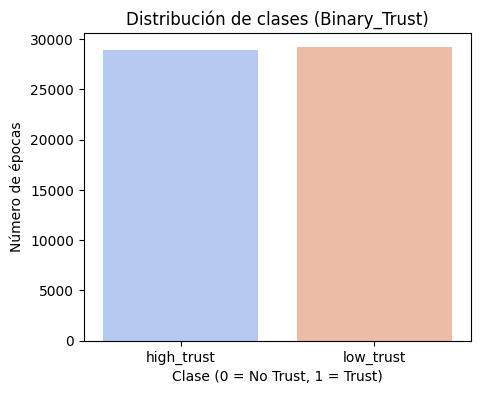

Distribución porcentual:
 Binary_Trust
low_trust     0.502625
high_trust    0.497375
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm')
plt.title("Distribución de clases (Binary_Trust)")
plt.xlabel("Clase (0 = No Trust, 1 = Trust)")
plt.ylabel("Número de épocas")
plt.show()

print("Distribución porcentual:\n", eeg1['Binary_Trust'].value_counts(normalize=True))

## Almacén de resultados

In [ ]:
import os

def save_f1_history(clf, architecture, participant):
    f1_curve = clf.history_[:, 'f1_macro']
    df_new = pd.DataFrame({
        'epoch': range(1, len(f1_curve)+1),
        'f1': f1_curve,
        'architecture': architecture,
        'participant': participant
    })

    filename = "historial_f1_global.csv"

    if os.path.exists(filename):
        df_old = pd.read_csv(filename)
        df_final = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df_final = df_new

    df_final.to_csv(filename, index=False)
    print(f"Guardado en {filename}")


## Red Neuronal EEGNet

In [9]:
from braindecode import EEGClassifier
from braindecode.models import EEGNet
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
from skorch.helper import predefined_split

In [13]:
fs = 1 / (eeg1['latency'].iloc[1] - eeg1['latency'].iloc[0])
print("Frecuencia de muestreo (Hz):", fs)

Frecuencia de muestreo (Hz): 256.42257137618384


### Trial Wise

Dividimos los datos de manera que no queden muestras mezcladas en los distintos conjuntos de entrenamiento, validación y test

In [62]:
# Identificar todos los trials (epochs)
epochs = eeg1['epoch'].dropna().unique()

# Asociar cada trial a su etiqueta de confianza binaria
binary_trust_in_epoch = eeg1.groupby('epoch')['Binary_Trust'].first()

# Dividir trials en train, test y validación
epochs_train, epochs_test = train_test_split(
    epochs,
    test_size=0.2,
    stratify=binary_trust_in_epoch.loc[epochs].values,
    random_state=42
)

# Dentro de train, split train/valid
epochs_train, epochs_valid = train_test_split(
    epochs_train,
    test_size=0.2,  
    stratify=binary_trust_in_epoch[epochs_train],
    random_state=42
)

df_train = eeg1[eeg1['epoch'].isin(epochs_train)].reset_index(drop=True)
df_valid = eeg1[eeg1['epoch'].isin(epochs_valid)].reset_index(drop=True)
df_test  = eeg1[eeg1['epoch'].isin(epochs_test)].reset_index(drop=True)

def make_trial_windows(df, window_size, stride):
    trials = df['epoch'].unique()
    X_list, y_list = [], []

    for trial in trials:
        trial_df = df[df['epoch']==trial].drop(columns=['latency','Trust','Binary_Trust','epoch'], errors='ignore')
        trial_signals = trial_df.values  
        label = df[df['epoch']==trial]['Binary_Trust'].iloc[0]
        label_bin = 0 if label=='low_trust' else 1

        # Extraer ventanas con stride
        for start in range(0, trial_signals.shape[0] - window_size + 1, stride):
            window = trial_signals[start:start+window_size, :]
            X_list.append(window.T)  
            y_list.append(label_bin)

    X_tensor = torch.tensor(X_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.long)

    return X_tensor, y_tensor

X_train_t, y_train_t = make_trial_windows(df_train, window_size=256, stride=32)
X_valid_t, y_valid_t = make_trial_windows(df_valid, window_size=256, stride=32)
X_test_t,  y_test_t  = make_trial_windows(df_test,  window_size=256, stride=32)

print(X_train_t.shape, y_train_t.shape)

torch.Size([380, 19, 256]) torch.Size([380])


### Selección de características

#### Métodos filter

In [ ]:
# Selección de canales (ANOVA) 
from sklearn.feature_selection import f_classif

# Convertimos a numpy y aplanamos por tiempo para tener una feature por canal
X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Calculamos F y p-values
F_values, pvals = f_classif(X_train_mean, y_np)

# Escogemos los canales con p<0.05 (significativos)
k = 10  
selected_channels = np.argsort(F_values)[-k:] 
print("Canales seleccionados:", selected_channels)


# Filtramos los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]

print("Nueva forma de X_train:", X_train_t.shape)


Canales seleccionados: [ 7  4  2  1  8 10  0 15 11  5]
Nueva forma de X_train: torch.Size([380, 10, 256])


In [48]:
from sklearn.feature_selection import mutual_info_classif

X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Mutual information
mi = mutual_info_classif(X_train_mean, y_np, random_state=42)
selected_channels = np.argsort(mi)[-10:]

print("Canales seleccionados (MI):", selected_channels)

# Filtra los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Nueva forma de X_train:", X_train_t.shape)

Canales seleccionados (MI): [13 10  1 17 15  3 11  6  5  2]
Nueva forma de X_train: torch.Size([380, 10, 256])


#### Método híbrido (filter+wrapper)

In [55]:
from sklearn.feature_selection import mutual_info_classif, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

X_mean = X_train_t.numpy().mean(axis=2)
mi = mutual_info_classif(X_mean, y_train_t.numpy(), random_state=42)
top_k = min(14, X_mean.shape[1])
top_channels = np.argsort(mi)[-top_k:]
X_filtered = X_mean[:, top_channels]

wrapper = SequentialFeatureSelector(
        LogisticRegression(max_iter=1000),
        n_features_to_select=min(10, top_k),
        direction='forward',
        n_jobs=-1
    )
wrapper.fit(X_filtered, y_train_t.numpy())
selected_channels = top_channels[wrapper.get_support()]
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Canales finales (híbrido):", selected_channels)


Canales finales (híbrido): [14  7 13 10  1 17  3 11  5  2]


#### Normalización de los datos

In [63]:
mean = X_train_t.mean(dim=(0,2), keepdim=True)  
std  = X_train_t.std(dim=(0,2), keepdim=True)
X_train_t = (X_train_t - mean) / (std + 1e-8)
X_valid_t = (X_valid_t - mean) / (std + 1e-8)
X_test_t  = (X_test_t - mean) / (std + 1e-8)


In [15]:
overlap = set(epochs_train).intersection(set(epochs_test))
print("Épocas repetidas en train y test:", overlap)

Épocas repetidas en train y test: set()


In [16]:
print("Train windows:", X_train_t.shape[0])
print("Valid windows:", X_valid_t.shape[0])
print("Test windows:",  X_test_t.shape[0])


Train windows: 380
Valid windows: 117
Test windows: 184


### Modelo y entrenamiento

#### Creación del modelo

In [12]:
chans = 19  
nb_classes = 2   

model = EEGNet(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
    F1=8,F2=16,
)

In [13]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

#### Entrenamiento del modelo

In [14]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='f1_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

recall_macro = EpochScoring(
    scoring='recall_macro', 
    lower_is_better=False,
    on_train=False,
    name='recall_macro',
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=5e-4,
    batch_size=64,
    callbacks=[f1_macro
               ],
    max_epochs=40,
    device='cpu',
)


In [15]:
clf.fit(X_train_t, y_train_t)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.4576        0.7472       0.4615        0.6953  0.4129
      2      0.3960        0.7093       0.4103        0.6950  0.3858
      3      0.3886        0.7065       0.4103        0.6952  0.4343
      4      0.3679        0.7038       0.3846        0.6961  0.4765
      5      0.3539        0.6673       0.3675        0.6975  0.3938
      6      0.3423        0.6755       0.3504        0.6991  0.3772
      7      0.3423        0.6718       0.3504        0.7007  0.4067
      8      0.3446        0.6759       0.3504        0.7020  0.3830
      9      0.3560        0.6537       0.3590        0.7037  0.3787
     10      0.3401        0.6469       0.3419        0.7054  0.5607
     11      0.3333        0.6516       0.3333        0.7077  0.3681
     12      0.3329        0.6379       0.3333        0.7104  0.5145
     13      0.3321        0.6237 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNet (EEGNet)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                                 [1, 19, 256]              [1, 19, 256, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                                [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  ├─Conv2d (conv_temporal): 1-3                                [1, 1, 19, 256]           [1, 8, 19, 257]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 19, 257]           [1, 8, 19, 257]           16                        --
  ├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 19, 257]           [1, 16, 1, 257]           --                        [19, 1]
  │    └─ModuleDict (parametrizations): 2-1                    --                        --                        --                        --
  │    │    └─ParametrizationList (weight): 3-1                --                        [16, 1, 19, 1]            304                       --
  ├─BatchNorm2d (bnorm_1): 1-6                                 [1, 16, 1, 257]           [1, 16, 1, 257]           32                        --
  ├─ELU (elu_1): 1-7                                           [1, 16, 1, 257]           [1, 16, 1, 257]           --                        --
  ├─AvgPool2d (pool_1): 1-8                                    [1, 16, 1, 257]           [1, 16, 1, 64]            --                        [1, 4]
  ├─Dropout (drop_1): 1-9                                      [1, 16, 1, 64]            [1, 16, 1, 64]            --                        --
  ├─Conv2d (conv_separable_depth): 1-10                        [1, 16, 1, 64]            [1, 16, 1, 65]            256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11                        [1, 16, 1, 65]            [1, 16, 1, 65]            256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                                [1, 16, 1, 65]            [1, 16, 1, 65]            32                        --
  ├─ELU (elu_2): 1-13                                          [1, 16, 1, 65]            [1, 16, 1, 65]            --                        --
  ├─AvgPool2d (pool_2): 1-14                                   [1, 16, 1, 65]            [1, 16, 1, 8]             --                        [1, 8]
  ├─Dropout (drop_2): 1-15                                     [1, 16, 1, 8]             [1, 16, 1, 8]             --                        --
  ├─Sequential (final_layer): 1-16                             [1, 16, 1, 8]             [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-2                         [1, 16, 1, 8]             [1, 2, 1, 1]              258                       [1, 8]
  │    └─Rearrange (permute_back): 2-3                         [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─SqueezeFinalOutput (squeeze): 2-4                     [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-2                         [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  ==========================================================================================================

#### Test

In [16]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[19 83]
 [ 8 74]]
              precision    recall  f1-score   support

           0       0.70      0.19      0.29       102
           1       0.47      0.90      0.62        82

    accuracy                           0.51       184
   macro avg       0.59      0.54      0.46       184
weighted avg       0.60      0.51      0.44       184



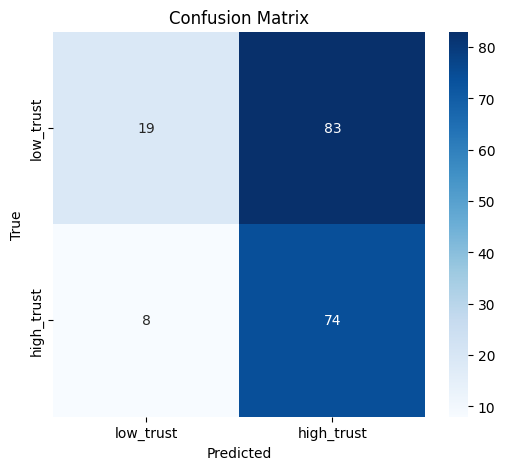

In [17]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1] 
y_true = y_test_t.numpy()

# ROC-AUC
roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.456


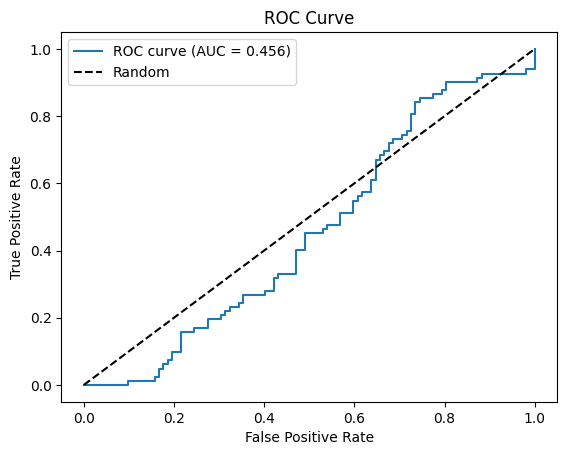

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Almacenamos los valores de f1-score durante la etapa de entrenamiento

In [108]:
save_f1_history(
    clf=clf,
    architecture="EEGNet",
    participant="P21"
)


Guardado en historial_f1_global.csv


### EEGNeX

In [20]:
from braindecode.models import EEGNeX

In [70]:
chans = 19
nb_classes = 2   

model = EEGNeX(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.6,
)

In [71]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

In [72]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='recall_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

recall_macro = EpochScoring(
    scoring='recall_macro',
    lower_is_better=False,
    on_train=False,
    name='recall_macro',
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=5e-4,
    batch_size=32,
    callbacks=[f1_macro
               ],
    max_epochs=30,
    device='cpu',
)

In [73]:
clf.fit(X_train_t, y_train_t)

  epoch    f1_macro    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3619        0.6928       0.3675        0.7042  23.9364
      2      0.4359        0.6385       0.4359        0.7392  19.4673
      3      0.4853        0.5867       0.4872        0.7200  19.5805
      4      0.4843        0.5630       0.5043        0.7062  12.0509
      5      0.5629        0.5099       0.5897        0.6310  15.8320
      6      0.5385        0.5107       0.5897        0.5810  18.4878
      7      0.5772        0.4816       0.6068        0.5772  19.1021
      8      0.5811        0.4501       0.6068        0.5506  22.5944
      9      0.6323        0.4117       0.6581        0.4996  20.3478
     10      0.5799        0.3737       0.6154        0.5173  18.9972
     11      0.6100        0.3612       0.6410        0.5138  23.2126
     12      0.6798        0.3243       0.7009        0.4708  18.8339
     13      0.6691 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNeX (EEGNeX)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Sequential (block_1): 1-1                                  [1, 19, 256]              [1, 8, 19, 256]           --                        --
  │    └─Rearrange (0): 2-1                                    [1, 19, 256]              [1, 1, 19, 256]           --                        --
  │    └─Conv2d (1): 2-2                                       [1, 1, 19, 256]           [1, 8, 19, 256]           512                       [1, 64]
  │    └─BatchNorm2d (2): 2-3                                  [1, 8, 19, 256]           [1, 8, 19, 256]           16                        --
  ├─Sequential (block_2): 1-2                                  [1, 8, 19, 256]           [1, 32, 19, 256]          --                        --
  │    └─Conv2d (0): 2-4                                       [1, 8, 19, 256]           [1, 32, 19, 256]          16,384                    [1, 64]
  │    └─BatchNorm2d (1): 2-5                                  [1, 32, 19, 256]          [1, 32, 19, 256]          64                        --
  ├─Sequential (block_3): 1-3                                  [1, 32, 19, 256]          [1, 64, 1, 64]            --                        --
  │    └─ParametrizedConv2dWithConstraint (0): 2-6             [1, 32, 19, 256]          [1, 64, 1, 256]           --                        [19, 1]
  │    │    └─ModuleDict (parametrizations): 3-1               --                        --                        1,216                     --
  │    └─BatchNorm2d (1): 2-7                                  [1, 64, 1, 256]           [1, 64, 1, 256]           128                       --
  │    └─ELU (2): 2-8                                          [1, 64, 1, 256]           [1, 64, 1, 256]           --                        --
  │    └─AvgPool2d (3): 2-9                                    [1, 64, 1, 256]           [1, 64, 1, 64]            --                        [1, 4]
  │    └─Dropout (4): 2-10                                     [1, 64, 1, 64]            [1, 64, 1, 64]            --                        --
  ├─Sequential (block_4): 1-4                                  [1, 64, 1, 64]            [1, 32, 1, 64]            --                        --
  │    └─Conv2d (0): 2-11                                      [1, 64, 1, 64]            [1, 32, 1, 64]            32,768                    [1, 16]
  │    └─BatchNorm2d (1): 2-12                                 [1, 32, 1, 64]            [1, 32, 1, 64]            64                        --
  ├─Sequential (block_5): 1-5                                  [1, 32, 1, 64]            [1, 64]                   --                        --
  │    └─Conv2d (0): 2-13                                      [1, 32, 1, 64]            [1, 8, 1, 64]             4,096                     [1, 16]
  │    └─BatchNorm2d (1): 2-14                                 [1, 8, 1, 64]             [1, 8, 1, 64]             16                        --
  │    └─ELU (2): 2-15                                         [1, 8, 1, 64]             [1, 8, 1, 64]             --                        --
  │    └─AvgPool2d (3): 2-16                                   [1, 8, 1, 64]             [1, 8, 1, 8]              --                        [1, 8]
  │    └─Dropout (4): 2-17                                     [1, 8, 1, 8]              [1, 8, 1, 8]     

In [74]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[90 12]
 [ 9 73]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       102
           1       0.86      0.89      0.87        82

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184



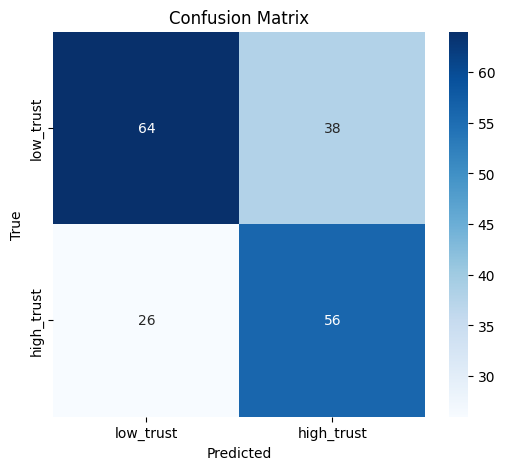

In [26]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [75]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

# Métricas
roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.905


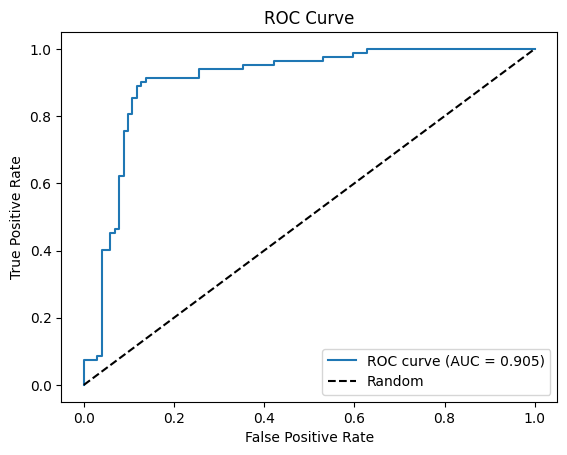

In [76]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Almacenamos los valores de f1-score

In [114]:
save_f1_history(
    clf=clf,
    architecture="EEGNeX",
    participant="P21"
)


Guardado en historial_f1_global.csv


### Almacén del modelo

In [ ]:
import os
import pickle

subject_id = 'P21'
folder_path = 'artifacts'
os.makedirs(folder_path, exist_ok=True)

# Guardar modelo y configuración
try:
    # Guardamos los pesos del modelo y optimizador 
    clf.save_params(
        f_params=os.path.join(folder_path, f'model_weights_{subject_id}.pt'),
        f_optimizer=os.path.join(folder_path, f'opt_{subject_id}.pt'),
        f_history=os.path.join(folder_path, f'history_{subject_id}.json')
    )
    
    # Guardamos los hiperparámetros 
    config_params = clf.get_params()
    config_params.pop('module', None) 
    
    with open(os.path.join(folder_path, f'config_{subject_id}.pkl'), 'wb') as f:
        pickle.dump(config_params, f)
    
except RuntimeError:
    import torch
    torch.save(clf.module_.state_dict(), os.path.join(folder_path, f'state_dict_{subject_id}.pt'))

# GUARDAR PREDICCIONES 
y_pred = clf.predict(X_test_t)
y_probs = clf.predict_proba(X_test_t)[:, 1]

df_preds = pd.DataFrame({
    'Real': y_test_t.cpu().numpy() if hasattr(y_test_t, 'cpu') else y_test_t,
    'Prediccion': y_pred,
    'Probabilidad': y_probs
})

df_preds.to_excel(os.path.join(folder_path, f'predicciones_{subject_id}.xlsx'), index=False)



## AttentionBaseNet

In [77]:
from braindecode.models import AttentionBaseNet


In [144]:
model = AttentionBaseNet(
    n_chans=10,
    n_outputs=2,
    n_times=256,
    drop_prob_inp=0.2,
    drop_prob_attn= 0.5,

)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=0.001,
    lower_is_better=True,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-3,
    batch_size=32,
    callbacks=[ 
               f1_macro,],
    max_epochs=30,
    device='cpu',
)


In [147]:
clf.fit(
    X_train_t, 
    y_train_t, 
)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2678        0.7049       0.3333        0.7390  0.4651
      2      0.4418        0.6351       0.4444        0.7245  0.5850
      3      0.4878        0.6069       0.5043        0.7184  1.5951
      4      0.4806        0.5832       0.5043        0.7131  0.7990
      5      0.5271        0.5762       0.5470        0.6892  0.6739
      6      0.6342        0.5386       0.6496        0.6290  0.9514
      7      0.6102        0.4925       0.6325        0.6424  0.4154
      8      0.6432        0.5067       0.6667        0.6309  0.4012
      9      0.6507        0.4719       0.6752        0.6253  0.3635
     10      0.6540        0.4336       0.6752        0.6211  0.4259
     11      0.6691        0.4030       0.6923        0.5765  0.3815
     12      0.6657        0.4438       0.6923        0.5585  0.3686
     13      0.6432        0.3991 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  AttentionBaseNet (AttentionBaseNet)                          [1, 10, 256]              [1, 2]                    --                        --
  ├─_FeatureExtractor (input_block): 1-1                       [1, 10, 256]              [1, 40, 1, 13]            --                        --
  │    └─Ensure4d (ensure4d): 2-1                              [1, 10, 256]              [1, 10, 256, 1]           --                        --
  │    └─Rearrange (rearrange_input): 2-2                      [1, 10, 256, 1]           [1, 1, 10, 256]           --                        --
  │    └─Conv2d (temporal_conv): 2-3                           [1, 1, 10, 256]           [1, 40, 10, 256]          1,000                     [1, 25]
  │    └─BatchNorm2d (intermediate_bn): 2-4                    [1, 40, 10, 256]          [1, 40, 10, 256]          80                        --
  │    └─Conv2d (spatial_conv): 2-5                            [1, 40, 10, 256]          [1, 40, 1, 256]           400                       [10, 1]
  │    └─BatchNorm2d (bn): 2-6                                 [1, 40, 1, 256]           [1, 40, 1, 256]           80                        --
  │    └─ELU (nonlinearity): 2-7                               [1, 40, 1, 256]           [1, 40, 1, 256]           --                        --
  │    └─AvgPool2d (pool): 2-8                                 [1, 40, 1, 256]           [1, 40, 1, 13]            --                        [1, 75]
  │    └─Dropout (dropout): 2-9                                [1, 40, 1, 13]            [1, 40, 1, 13]            --                        --
  ├─Sequential (channel_expansion): 1-2                        [1, 40, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─Conv2d (0): 2-10                                      [1, 40, 1, 13]            [1, 16, 1, 13]            640                       [1, 1]
  │    └─BatchNorm2d (1): 2-11                                 [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    └─ELU (2): 2-12                                         [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  ├─_ChannelAttentionBlock (channel_attention_block): 1-3      [1, 16, 1, 13]            [1, 16, 1, 1]             --                        --
  │    └─Sequential (conv): 2-13                               [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    │    └─Conv2d (0): 3-1                                  [1, 16, 1, 13]            [1, 16, 1, 13]            240                       [1, 15]
  │    │    └─Conv2d (1): 3-2                                  [1, 16, 1, 13]            [1, 16, 1, 13]            256                       [1, 1]
  │    │    └─BatchNorm2d (2): 3-3                             [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    │    └─ELU (3): 3-4                                     [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─AvgPool2d (pool): 2-14                                [1, 16, 1, 13]            [1, 16, 1, 1]             --                        [1, 8]
  │    └─Dropout (dropout): 2-15                               [1, 16, 1, 1]             [1, 16, 1, 1]             --                        --
  ├─Sequential (final_layer): 1-4                              [1, 16, 1, 1]             [1, 2]            

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[64 38]
 [22 60]]
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       102
           1       0.61      0.73      0.67        82

    accuracy                           0.67       184
   macro avg       0.68      0.68      0.67       184
weighted avg       0.69      0.67      0.67       184



In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1] 
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.747


In [126]:
save_f1_history(
    clf=clf,
    architecture="AttentionBaseNet",
    participant="P21"
)

Guardado en historial_f1_global.csv
